# Preprocessing Data

Pipeline cho bộ dữ liệu đã gom theo topic trong cấu trúc thư mục:

```text
project_root/
  data_filtered/
    Ẩm thực/
      AT_VNE_1.txt
      ...
    Du lịch/
      DL_VNE_1.txt
      ...
    ... (21 topic)
```

Notebook này thực hiện 4 bước:
1. Load toàn bộ `.txt` trong từng topic, xử lý **duplicate** (theo nội dung text trong từng topic) và di chuyển file trùng vào thư mục `_duplicates` của topic đó.
2. **Length check**: nếu bài có độ dài `< 70` ký tự thì xem là quá ngắn, di chuyển vào thư mục `_too_short`.
3. Chọn **5% bài trong từng topic** làm sample để **spot checking** thủ công, xuất ra file `spot_check_samples.csv`.
4. **Imbalance check** giữa các topic sau khi làm sạch và vẽ line chart số bài theo topic.


In [1]:
# Cấu hình đường dẫn chính
from pathlib import Path

# Thư mục chứa dữ liệu
DATA_ROOT = Path("data_filtered")

DATA_ROOT.resolve()

WindowsPath('C:/Users/yello/PycharmProjects/NLP/data_filtered')

## 1. Import thư viện và hàm hỗ trợ


In [2]:
import os
import hashlib
import shutil
import random

import pandas as pd
import matplotlib.pyplot as plt

random.seed(42)
pd.set_option("display.max_colwidth", 200)

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    return " ".join(text.split()).strip()

def file_hash(text: str) -> str:
    norm = normalize_text(text)
    return hashlib.md5(norm.encode("utf-8")).hexdigest()

DATA_ROOT.exists(), list(DATA_ROOT.iterdir())[:5]

(True,
 [WindowsPath('data_filtered/Bất động sản'),
  WindowsPath('data_filtered/Chứng khoán'),
  WindowsPath('data_filtered/Công nghệ'),
  WindowsPath('data_filtered/Du lịch'),
  WindowsPath('data_filtered/Gia đình')])

## 2. Load toàn bộ dữ liệu thành DataFrame

- Mỗi file `.txt` là một bài.
- `topic` = tên thư mục con (ví dụ `"Ẩm thực"`).
- `filename` = tên file.
- `file_path` = đường dẫn đầy đủ.
- `text` = nội dung bài.


In [3]:
def safe_read_text(path: Path) -> str:
    """
    Đọc file .txt và làm sạch:
    - Thử lần lượt UTF-8, UTF-8-SIG, UTF-16 (LE/BE)
    - Loại bỏ ký tự NULL (\x00), zero-width space, v.v.
    """
    data = path.read_bytes()

    text = None
    for enc in ("utf-8-sig", "utf-8", "utf-16", "utf-16-le", "utf-16-be"):
        try:
            text = data.decode(enc)
            break
        except UnicodeDecodeError:
            continue

    if text is None:
        # fallback: UTF-8 ignore
        text = data.decode("utf-8", errors="ignore")

    # Loại NULL + một số ký tự khó chịu
    text = (
        text.replace("\x00", "")
            .replace("\u200b", "")  # zero-width space
    )

    return text.strip()

In [4]:
rows = []

for topic_dir in DATA_ROOT.iterdir():
    if not topic_dir.is_dir():
        continue
    topic = topic_dir.name
    for txt_file in topic_dir.glob("*.txt"):
        try:
            text = safe_read_text(txt_file)
        except Exception as e:
            print(f"[WARN] Không đọc được file {txt_file}: {e}")
            continue

        rows.append({
            "topic": topic,
            "filename": txt_file.name,
            "file_path": str(txt_file),
            "text": text,
        })

df = pd.DataFrame(rows)
print("Số bài tổng cộng:", len(df))
df.head()


Số bài tổng cộng: 127160


,topic,filename,file_path,text
0,Bất động sản,BDS_00052_1.txt,data_filtered\Bất động sản\BDS_00052_1.txt,"Title: Sổ đỏ có nét đứt vẽ tay phân định đất ở và đất nông nghiệp: Bỏ đi được không?\r\n\r\nMột công dân cho biết, gia đình có mảnh đất, gồm đất ở và đất trồng cây lâu năm. Mảnh đất này do bố mẹ đ..."
1,Bất động sản,BDS_CAF_1.txt,data_filtered\Bất động sản\BDS_CAF_1.txt,"Kết thúc phiên giao dịch ngày 7/12, thị trường chứng khoán đã chứng kiến một pha rung lắc mạnh khi VN-Index giảm gần 5 điểm còn 1.121 điểm. Có lúc trong phiên VN-Index đã giảm gần 20 điểm.\r\n\r\n..."
2,Bất động sản,BDS_CAF_2.txt,data_filtered\Bất động sản\BDS_CAF_2.txt,"Thị trường bất động sản đã trải qua một năm Quý Mão 2023 trầm lắng, thậm chí đóng băng ở nhiều phân khúc. Tuy nhiên, những dấu hiệu khởi sắc đã xuất hiện vào cuối năm mang đến những hy vọng về một..."
3,Bất động sản,BDS_CAF_3.txt,data_filtered\Bất động sản\BDS_CAF_3.txt,"Quy phạm hóa dữ liệu bất động sản\r\n\r\nQuốc hội mới đây đã có phiên toàn thể về giải trình tiếp thu, chỉnh lý dự thảo Luật Kinh doanh bất động sản (sửa đổi). Nhìn chung các đại biểu cho biết dự ..."
4,Bất động sản,BDS_CAF_4.txt,data_filtered\Bất động sản\BDS_CAF_4.txt,"Thị trường bất động sản đã bước sang nửa cuối năm 2023, song vẫn tiếp tục duy trì nhịp độ trầm lắng. Tuy nhiên, tình trạng rao bán giảm giá bán bất động sản, đặc biệt là phân khúc đất nền vẫn diễn..."


In [5]:
from pathlib import Path

ROOT = Path(r"C:\Users\yello\PycharmProjects\NLP\data")  # Folder chứa data

def convert_to_utf8(path: Path):
    try:
        # Bước 1: Đọc byte
        raw_data = path.read_bytes()

        # Bước 2: Thử decode xem nó là gì
        try:
            # Thử UTF-8 trước
            content = raw_data.decode('utf-8')
            # Nếu thành công mà không lỗi -> File đã chuẩn, không cần làm gì
            return False
        except UnicodeDecodeError:
            # Nếu lỗi -> Chắc là UTF-16 LE
            try:
                content = raw_data.decode('utf-16')
            except UnicodeDecodeError:
                print(f"❌ Không đọc được file: {path.name} (Không phải utf-8 cũng ko phải utf-16)")
                return False

        # Bước 3: Ghi đè lại bằng chuẩn UTF-8
        path.write_text(content, encoding='utf-8')
        print(f"✅ Đã sửa file: {path.name} (UTF-16 -> UTF-8)")
        return True

    except Exception as e:
        print(f"Lỗi file {path.name}: {e}")
        return False

# Chạy vòng lặp quét folder
count_fixed = 0
for txt_path in ROOT.rglob("*.txt"):
    if convert_to_utf8(txt_path):
        count_fixed += 1

print(f"Tổng cộng đã sửa {count_fixed} file về chuẩn UTF-8.")

Tổng cộng đã sửa 0 file về chuẩn UTF-8.


In [6]:
from pathlib import Path
import shutil

# =========================
# CHỈNH Ở ĐÂY
# =========================
DEST_ROOT = DATA_ROOT.parent / f"{DATA_ROOT.name}_corrupted"

DEST_ROOT.mkdir(parents=True, exist_ok=True)

def is_corrupted_utf16_like(path: Path) -> bool:
    """
    Heuristic: file 'nghi ngờ hư' nếu có nhiều byte NULL (0x00),
    đặc trưng của UTF-16 bị đọc/ghi sai.
    """
    try:
        data = path.read_bytes()
    except Exception:
        return False # Không đọc được thì bỏ qua hoặc xử lý riêng

    if not data:
        return False  # file rỗng thì bỏ qua

    # Lấy mẫu tối đa 4KB để đo
    sample = data[:4096]
    null_count = sample.count(0)  # số byte 0x00

    if null_count == 0:
        return False

    ratio = null_count / len(sample)
    # Nếu > 5% byte là 0x00 thì xem như 'corrupted utf16-like'
    return ratio > 0.05


total_files = 0
corrupted_files = 0
copied_files = 0  # Đổi tên biến đếm cho đúng ngữ nghĩa

print(f"Đang quét thư mục: {DATA_ROOT} ...")

for txt_path in DATA_ROOT.rglob("*.txt"):
    total_files += 1
    if is_corrupted_utf16_like(txt_path):
        corrupted_files += 1

        # Giữ nguyên cấu trúc thư mục con
        rel = txt_path.relative_to(DATA_ROOT)
        dest_path = DEST_ROOT / rel
        dest_path.parent.mkdir(parents=True, exist_ok=True)

        # ========================================================
        # THAY ĐỔI Ở ĐÂY: Dùng copy2 thay vì move
        # ========================================================
        shutil.copy2(str(txt_path), str(dest_path))
        copied_files += 1

print("-" * 30)
print("Tổng số file .txt quét:", total_files)
print("Số file nghi ngờ bị hư (utf16-like):", corrupted_files)
print("Số file đã SAO CHÉP sang:", DEST_ROOT)

Đang quét thư mục: data_filtered ...
------------------------------
Tổng số file .txt quét: 129530
Số file nghi ngờ bị hư (utf16-like): 0
Số file đã SAO CHÉP sang: data_filtered_corrupted


## 3. Xử lý duplicate trong từng topic

Tiêu chí duplicate:
- Cùng `topic`.
- Cùng `text_hash` (hash của nội dung đã normalize).

Giữ lại bản xuất hiện đầu tiên, các bản trùng sau:
- Được di chuyển sang thư mục con `_duplicates` trong topic tương ứng.
- Không dùng trong `df_nodup` (dataset sạch sau bước này).


In [7]:
import os
import re

# =========================
# CẤU HÌNH ĐƯỜNG DẪN
# =========================
# Thay đường dẫn tới thư mục data của bạn ở đây

def remove_url_lines(file_path):
    """
    Đọc file, loại bỏ các dòng chứa http/https/www, sau đó ghi đè lại.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()

        new_lines = []
        removed_count = 0

        # Regex bắt link: http://, https://, www.
        url_pattern = re.compile(r'(http[s]?://|www\.)')

        for line in lines:
            # Nếu dòng chứa link hoặc bắt đầu bằng "Url:" -> Bỏ qua
            if url_pattern.search(line) or line.strip().startswith("Url:"):
                removed_count += 1
                continue

            new_lines.append(line)

        # Nếu có dòng bị xóa thì mới ghi lại file để đỡ tốn thời gian
        if removed_count > 0:
            with open(file_path, 'w', encoding='utf-8') as f:
                f.writelines(new_lines)
            return removed_count

    except Exception as e:
        print(f"Lỗi file {file_path}: {e}")

    return 0

def main():
    total_files = 0
    total_lines_removed = 0

    print(f"Đang quét thư mục: {DATA_ROOT} ...")

    # Duyệt qua tất cả các thư mục con
    for root, dirs, files in os.walk(DATA_ROOT):
        for file in files:
            if file.endswith(".txt"):
                file_path = os.path.join(root, file)
                total_files += 1

                # Gọi hàm xóa
                removed = remove_url_lines(file_path)

                if removed > 0:
                    total_lines_removed += removed
                    # In ra để biết file nào vừa được sửa (tùy chọn)
                    # print(f"Đã xóa {removed} dòng link trong: {file}")

    print("-" * 30)
    print(f"Hoàn tất!")
    print(f"Tổng số file đã quét: {total_files}")
    print(f"Tổng số dòng link đã xóa: {total_lines_removed}")

if __name__ == "__main__":
    main()

Đang quét thư mục: data_filtered ...
------------------------------
Hoàn tất!
Tổng số file đã quét: 129530
Tổng số dòng link đã xóa: 0


In [8]:
if df.empty:
    raise ValueError("DataFrame rỗng, kiểm tra lại DATA_ROOT.")

df["norm_text"] = df["text"].apply(normalize_text)
df["text_hash"] = df["norm_text"].apply(file_hash)

# Xác định duplicate trong từng topic
df["is_duplicate"] = df.duplicated(subset=["topic", "text_hash"], keep="first")

dups = df[df["is_duplicate"]].copy()
print("Số bài duplicate tìm được:", len(dups))
dups.groupby("topic")["filename"].count()

Số bài duplicate tìm được: 17


topic
Chứng khoán     1
Công nghệ       1
Kinh doanh      1
Văn hóa        11
Ẩm thực         3
Name: filename, dtype: int64

In [9]:
for row in dups.itertuples(index=False):
    file_path = Path(row.file_path)
    topic_dir = file_path.parent
    dup_dir = topic_dir / "_duplicates"
    dup_dir.mkdir(exist_ok=True)
    target_path = dup_dir / file_path.name
    if not target_path.exists():
        shutil.move(str(file_path), str(target_path))

df_nodup = df[~df["is_duplicate"]].copy().reset_index(drop=True)
print("Số bài sau khi bỏ duplicate:", len(df_nodup))
df_nodup.head()

Số bài sau khi bỏ duplicate: 127143


,topic,filename,file_path,text,norm_text,text_hash,is_duplicate
0,Bất động sản,BDS_00052_1.txt,data_filtered\Bất động sản\BDS_00052_1.txt,"Title: Sổ đỏ có nét đứt vẽ tay phân định đất ở và đất nông nghiệp: Bỏ đi được không?\r\n\r\nMột công dân cho biết, gia đình có mảnh đất, gồm đất ở và đất trồng cây lâu năm. Mảnh đất này do bố mẹ đ...","Title: Sổ đỏ có nét đứt vẽ tay phân định đất ở và đất nông nghiệp: Bỏ đi được không? Một công dân cho biết, gia đình có mảnh đất, gồm đất ở và đất trồng cây lâu năm. Mảnh đất này do bố mẹ đứng tên...",82af0a622122181dbac5a1c669fc4222,False
1,Bất động sản,BDS_CAF_1.txt,data_filtered\Bất động sản\BDS_CAF_1.txt,"Kết thúc phiên giao dịch ngày 7/12, thị trường chứng khoán đã chứng kiến một pha rung lắc mạnh khi VN-Index giảm gần 5 điểm còn 1.121 điểm. Có lúc trong phiên VN-Index đã giảm gần 20 điểm.\r\n\r\n...","Kết thúc phiên giao dịch ngày 7/12, thị trường chứng khoán đã chứng kiến một pha rung lắc mạnh khi VN-Index giảm gần 5 điểm còn 1.121 điểm. Có lúc trong phiên VN-Index đã giảm gần 20 điểm. Tuy nhi...",b42e0156f9b50e3e69026b6c72e9dcef,False
2,Bất động sản,BDS_CAF_2.txt,data_filtered\Bất động sản\BDS_CAF_2.txt,"Thị trường bất động sản đã trải qua một năm Quý Mão 2023 trầm lắng, thậm chí đóng băng ở nhiều phân khúc. Tuy nhiên, những dấu hiệu khởi sắc đã xuất hiện vào cuối năm mang đến những hy vọng về một...","Thị trường bất động sản đã trải qua một năm Quý Mão 2023 trầm lắng, thậm chí đóng băng ở nhiều phân khúc. Tuy nhiên, những dấu hiệu khởi sắc đã xuất hiện vào cuối năm mang đến những hy vọng về một...",4016109d87c384a6b96ff6c6d6b60412,False
3,Bất động sản,BDS_CAF_3.txt,data_filtered\Bất động sản\BDS_CAF_3.txt,"Quy phạm hóa dữ liệu bất động sản\r\n\r\nQuốc hội mới đây đã có phiên toàn thể về giải trình tiếp thu, chỉnh lý dự thảo Luật Kinh doanh bất động sản (sửa đổi). Nhìn chung các đại biểu cho biết dự ...","Quy phạm hóa dữ liệu bất động sản Quốc hội mới đây đã có phiên toàn thể về giải trình tiếp thu, chỉnh lý dự thảo Luật Kinh doanh bất động sản (sửa đổi). Nhìn chung các đại biểu cho biết dự thảo lu...",1321742a1452b33c08e845b2fe00a106,False
4,Bất động sản,BDS_CAF_4.txt,data_filtered\Bất động sản\BDS_CAF_4.txt,"Thị trường bất động sản đã bước sang nửa cuối năm 2023, song vẫn tiếp tục duy trì nhịp độ trầm lắng. Tuy nhiên, tình trạng rao bán giảm giá bán bất động sản, đặc biệt là phân khúc đất nền vẫn diễn...","Thị trường bất động sản đã bước sang nửa cuối năm 2023, song vẫn tiếp tục duy trì nhịp độ trầm lắng. Tuy nhiên, tình trạng rao bán giảm giá bán bất động sản, đặc biệt là phân khúc đất nền vẫn diễn...",2cbddcc166567c9222820a5c611dc664,False


## 4. Length check: bỏ bài quá ngắn (< 70 ký tự)

Bài nào `len(text) < 70`:
- Di chuyển sang thư mục `_too_short` trong topic tương ứng.
- Không dùng trong `df_clean`.


In [10]:
df_nodup["char_len"] = (
    df_nodup["norm_text"]
      .str.replace(" ", "", regex=False)
      .str.len()
)

too_short_mask = df_nodup["char_len"] < 70
short_df = df_nodup[too_short_mask].copy()
print("Số bài quá ngắn (<70 ký tự, không tính khoảng trắng):", len(short_df))
short_df.groupby("topic")["filename"].count()


Số bài quá ngắn (<70 ký tự, không tính khoảng trắng): 0


Series([], Name: filename, dtype: int64)

In [11]:
for row in short_df.itertuples(index=False):
    file_path = Path(row.file_path)
    topic_dir = file_path.parent
    short_dir = topic_dir / "_too_short"
    short_dir.mkdir(exist_ok=True)
    target_path = short_dir / file_path.name
    if not target_path.exists():
        shutil.move(str(file_path), str(target_path))

df_clean = df_nodup[~too_short_mask].copy().reset_index(drop=True)
print("Số bài sau khi lọc duplicate và length:", len(df_clean))
df_clean.head()

Số bài sau khi lọc duplicate và length: 127143


,topic,filename,file_path,text,norm_text,text_hash,is_duplicate,char_len
0,Bất động sản,BDS_00052_1.txt,data_filtered\Bất động sản\BDS_00052_1.txt,"Title: Sổ đỏ có nét đứt vẽ tay phân định đất ở và đất nông nghiệp: Bỏ đi được không?\r\n\r\nMột công dân cho biết, gia đình có mảnh đất, gồm đất ở và đất trồng cây lâu năm. Mảnh đất này do bố mẹ đ...","Title: Sổ đỏ có nét đứt vẽ tay phân định đất ở và đất nông nghiệp: Bỏ đi được không? Một công dân cho biết, gia đình có mảnh đất, gồm đất ở và đất trồng cây lâu năm. Mảnh đất này do bố mẹ đứng tên...",82af0a622122181dbac5a1c669fc4222,False,2347
1,Bất động sản,BDS_CAF_1.txt,data_filtered\Bất động sản\BDS_CAF_1.txt,"Kết thúc phiên giao dịch ngày 7/12, thị trường chứng khoán đã chứng kiến một pha rung lắc mạnh khi VN-Index giảm gần 5 điểm còn 1.121 điểm. Có lúc trong phiên VN-Index đã giảm gần 20 điểm.\r\n\r\n...","Kết thúc phiên giao dịch ngày 7/12, thị trường chứng khoán đã chứng kiến một pha rung lắc mạnh khi VN-Index giảm gần 5 điểm còn 1.121 điểm. Có lúc trong phiên VN-Index đã giảm gần 20 điểm. Tuy nhi...",b42e0156f9b50e3e69026b6c72e9dcef,False,2157
2,Bất động sản,BDS_CAF_2.txt,data_filtered\Bất động sản\BDS_CAF_2.txt,"Thị trường bất động sản đã trải qua một năm Quý Mão 2023 trầm lắng, thậm chí đóng băng ở nhiều phân khúc. Tuy nhiên, những dấu hiệu khởi sắc đã xuất hiện vào cuối năm mang đến những hy vọng về một...","Thị trường bất động sản đã trải qua một năm Quý Mão 2023 trầm lắng, thậm chí đóng băng ở nhiều phân khúc. Tuy nhiên, những dấu hiệu khởi sắc đã xuất hiện vào cuối năm mang đến những hy vọng về một...",4016109d87c384a6b96ff6c6d6b60412,False,5139
3,Bất động sản,BDS_CAF_3.txt,data_filtered\Bất động sản\BDS_CAF_3.txt,"Quy phạm hóa dữ liệu bất động sản\r\n\r\nQuốc hội mới đây đã có phiên toàn thể về giải trình tiếp thu, chỉnh lý dự thảo Luật Kinh doanh bất động sản (sửa đổi). Nhìn chung các đại biểu cho biết dự ...","Quy phạm hóa dữ liệu bất động sản Quốc hội mới đây đã có phiên toàn thể về giải trình tiếp thu, chỉnh lý dự thảo Luật Kinh doanh bất động sản (sửa đổi). Nhìn chung các đại biểu cho biết dự thảo lu...",1321742a1452b33c08e845b2fe00a106,False,5222
4,Bất động sản,BDS_CAF_4.txt,data_filtered\Bất động sản\BDS_CAF_4.txt,"Thị trường bất động sản đã bước sang nửa cuối năm 2023, song vẫn tiếp tục duy trì nhịp độ trầm lắng. Tuy nhiên, tình trạng rao bán giảm giá bán bất động sản, đặc biệt là phân khúc đất nền vẫn diễn...","Thị trường bất động sản đã bước sang nửa cuối năm 2023, song vẫn tiếp tục duy trì nhịp độ trầm lắng. Tuy nhiên, tình trạng rao bán giảm giá bán bất động sản, đặc biệt là phân khúc đất nền vẫn diễn...",2cbddcc166567c9222820a5c611dc664,False,3524


## 5. Spot checking: chọn mẫu thủ công cho 1 hoặc nhiều topic

- Bạn tự chỉ định:
  - Topic (hoặc danh sách topic) muốn kiểm tra.
  - Số lượng bài lấy mẫu mỗi topic.
- Kết quả lưu vào `spot_check_samples.csv` để mở bằng Excel / pandas và kiểm tra thủ công.


In [12]:
# available_topics = sorted(df_clean["topic"].unique())
# print("Các topic hiện có:", available_topics)
#
# #Chọn 1 topic cần kiểm tra:
# TOPICS_TO_CHECK = ["Ẩm thực", "Bất động sản", "Chứng khoán", "Công nghệ", "Đời sống"]  # hoặc ["Du lịch", "Chứng khoán"]
#
# #Số lượng bài muốn lấy mẫu mỗi topic:
# N_SAMPLE_PER_TOPIC = 300
#
# output_path = "spot_check_samples.xlsx"
#
# spot_parts = []
#
# for topic in TOPICS_TO_CHECK:
#     if topic not in available_topics:
#         print(f"[BỎ QUA] Topic '{topic}' không có trong df_clean.")
#         continue
#
#     group = df_clean[df_clean["topic"] == topic]
#     n = len(group)
#     if n == 0:
#         print(f"[BỎ QUA] Topic '{topic}' hiện không còn bài nào sau khi lọc.")
#         continue
#
#     k = min(N_SAMPLE_PER_TOPIC, n)
#     sample = group.sample(n=k, random_state=42)
#     spot_parts.append(sample)
#     print(f"Topic '{topic}': {n} bài, chọn {k} bài để spot check.")
#
# if spot_parts:
#     spot_df = pd.concat(spot_parts, ignore_index=True)
# else:
#     spot_df = pd.DataFrame(columns=df_clean.columns)
#
# spot_out = spot_df[["topic", "filename", "file_path", "char_len", "text"]].copy()
# with pd.ExcelWriter(output_path, engine="xlsxwriter") as writer:
#     spot_out.to_excel(writer, sheet_name="spot_check", index=False)
#
#     workbook  = writer.book
#     worksheet = writer.sheets["spot_check"]
#
#     n_rows, n_cols = spot_out.shape
#
#     header_fmt = workbook.add_format({
#         "font_name": "Ariel",   # hoặc Arial
#         "font_size": 13,
#         "bold": True,
#         "valign": "vcenter",
#         "text_wrap": True,
#     })
#
#     cell_fmt = workbook.add_format({
#         "font_name": "Ariel",
#         "font_size": 13,
#         "valign": "vcenter",
#         "text_wrap": True,
#     })
#
#     # header
#     worksheet.set_row(0, None, header_fmt)
#
#     # data rows
#     for r in range(1, n_rows + 1):
#         worksheet.set_row(r, None, cell_fmt)
#
#     worksheet.set_column(0, n_cols - 1, 20, cell_fmt)
#
#
# spot_out.head()


In [17]:
import pandas as pd
import numpy as np
import re
import shutil
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# ====================================================
# 1. CẤU HÌNH
# ====================================================

# Đảm bảo DATA_ROOT đúng
try:
    if 'DATA_ROOT' not in globals():
        DATA_ROOT = Path("data_filtered")
except NameError:
    DATA_ROOT = Path("data_filtered")


print("DATA_ROOT:", DATA_ROOT)
# Mapping 20 Topic
TOPIC_TO_ABBR = {
    "Bất động sản": "BDS", "Chứng khoán": "CK", "Công nghệ": "CN", "Du lịch": "DL",
    "Gia đình": "GD", "Giao thông": "GT", "Giáo dục": "GDU", "Giải trí": "GTRI",
    "Khoa học": "KH", "Khởi nghiệp": "KN", "Kinh doanh": "KD", "Nông nghiệp": "NN",
    "Pháp luật": "PL", "Sức khỏe": "SK", "Thế giới": "TG", "Thể thao": "TT",
    "Thời sự – Chính trị": "TSCQ", "Văn hóa": "VH", "Đời sống": "DS", "Ẩm thực": "AT",
}

# Ngưỡng tin cậy để move (0.9 = 90%)
CONFIDENCE_THRESHOLD = 0.9

# ====================================================
# 2. ML PHÁT HIỆN LỖI (GIỮ NGUYÊN)
# ====================================================

print("--- 🧠 BƯỚC 1: ML PHÁT HIỆN LỖI NHÃN ---")
# Lấy cả cột text để sau này xuất báo cáo
work_df = df_clean.copy()

print(f"Bắt đầu huấn luyện mô hình trên {len(work_df)} bài...")

# A. TF-IDF
tfidf = TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=5)
X = tfidf.fit_transform(work_df['text'])
y = work_df['topic']

# B. Model Predict
clf = LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag')
y_pred = cross_val_predict(clf, X, y, cv=3, n_jobs=-1)
y_proba = cross_val_predict(clf, X, y, cv=3, method='predict_proba', n_jobs=-1)

# C. Tính Confidence
classes = clf.fit(X, y).classes_
work_df['predicted_topic'] = y_pred
prob_indices = [np.where(classes == p)[0][0] for p in y_pred]
work_df['confidence'] = [probs[idx] for probs, idx in zip(y_proba, prob_indices)]

# D. Lọc bài sai
suspicious_df = work_df[
    (work_df['topic'] != work_df['predicted_topic']) &
    (work_df['confidence'] >= CONFIDENCE_THRESHOLD)
].copy()

suspicious_df = suspicious_df.sort_values('confidence', ascending=False)
print(f"✅ Phát hiện {len(suspicious_df)} bài nghi ngờ sai nhãn.")

# ====================================================
# 3. DI CHUYỂN & XUẤT BÁO CÁO KÈM TEXT
# ====================================================

print("\n--- 🔨 BƯỚC 2: DI CHUYỂN VÀ TẠO BÁO CÁO ---")

# >>> CẬP NHẬT Ở ĐÂY: Thêm cột 'text' và 'confidence' vào danh sách cần xử lý
move_list = suspicious_df[['file_path', 'filename', 'topic', 'predicted_topic', 'text', 'confidence']].copy()

# Thêm cột lưu đường dẫn mới để dễ theo dõi
move_list['new_file_path'] = ""

index_cache = {}
moved_count = 0
error_count = 0

# Helper functions
def get_source_from_filename(filename):
    try:
        parts = filename.replace(".txt", "").split("_")
        return parts[1] if len(parts) >= 3 else "UNKNOWN"
    except: return "UNKNOWN"

def get_next_index_memory(folder_path, prefix, current_max_cache):
    key = f"{folder_path}_{prefix}"
    if key not in current_max_cache:
        max_idx = 0
        if folder_path.exists():
            for f in folder_path.glob(f"{prefix}_*.txt"):
                try:
                    match = re.search(r'_(\d+)\.txt$', f.name)
                    if match: max_idx = max(max_idx, int(match.group(1)))
                except: continue
        current_max_cache[key] = max_idx
    current_max_cache[key] += 1
    return current_max_cache[key]

# Vòng lặp Move
for idx, row in move_list.iterrows():
    old_path = Path(row['file_path'])
    new_topic = row['predicted_topic']

    if not old_path.exists(): continue

    new_abbr = TOPIC_TO_ABBR.get(new_topic, "OTHER")
    source = get_source_from_filename(row['filename'])

    dest_folder = DATA_ROOT / new_topic
    dest_folder.mkdir(parents=True, exist_ok=True)

    file_prefix = f"{new_abbr}_{source}"
    new_index = get_next_index_memory(dest_folder, file_prefix, index_cache)
    new_filename = f"{file_prefix}_{new_index}.txt"
    new_path = dest_folder / new_filename

    try:
        shutil.move(str(old_path), str(new_path))

        # Cập nhật đường dẫn mới vào bảng báo cáo
        move_list.at[idx, 'new_file_path'] = str(new_path)

        # Cập nhật ngược lại df_clean (để bộ nhớ đồng bộ với ổ cứng)
        df_clean.loc[df_clean['file_path'] == str(old_path), 'topic'] = new_topic
        df_clean.loc[df_clean['file_path'] == str(old_path), 'file_path'] = str(new_path)

        moved_count += 1
    except Exception as e:
        error_count += 1
        print(f"❌ Lỗi: {e}")

print("-" * 30)
print(f"🎉 Đã di chuyển xong {moved_count} file.")

# >>> XUẤT EXCEL KÈM TEXT
# Sắp xếp lại cột cho dễ nhìn
report_columns = ['topic', 'predicted_topic', 'confidence', 'filename', 'new_file_path', 'text']
output_file = "moved_articles_report_FULL.xlsx"

print(f"Đang xuất file Excel kèm nội dung text: {output_file} ...")
move_list[report_columns].to_excel(output_file, index=False)

print("✅ Đã xong! Bạn hãy mở file Excel lên để kiểm tra nội dung.")

DATA_ROOT: data_filtered
--- 🧠 BƯỚC 1: ML PHÁT HIỆN LỖI NHÃN ---
Bắt đầu huấn luyện mô hình trên 127143 bài...
✅ Phát hiện 18 bài nghi ngờ sai nhãn.

--- 🔨 BƯỚC 2: DI CHUYỂN VÀ TẠO BÁO CÁO ---
------------------------------
🎉 Đã di chuyển xong 18 file.
Đang xuất file Excel kèm nội dung text: moved_articles_report_FULL.xlsx ...
✅ Đã xong! Bạn hãy mở file Excel lên để kiểm tra nội dung.


In [ ]:
import pandas as pd
import numpy as np
import re
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# ====================================================
# 1. CẤU HÌNH
# ====================================================
SOURCE_TOPIC = "Xã hội"  # Topic cần giải tán

# Mapping Topic (Đã bỏ Xã hội ra khỏi danh sách đích đến)
TOPIC_TO_ABBR = {
    "Bất động sản": "BDS", "Chứng khoán": "CK", "Công nghệ": "CN", "Du lịch": "DL",
    "Gia đình": "GD", "Giao thông": "GT", "Giáo dục": "GDU", "Giải trí": "GTRI",
    "Khoa học": "KH", "Khởi nghiệp": "KN", "Kinh doanh": "KD", "Nông nghiệp": "NN",
    "Pháp luật": "PL", "Sức khỏe": "SK", "Thế giới": "TG", "Thể thao": "TT",
    "Thời sự – Chính trị": "TSCQ", "Văn hóa": "VH", "Đời sống": "DS", "Ẩm thực": "AT",
}

try:
    if 'DATA_ROOT' not in globals(): DATA_ROOT = Path("data_filtered")
except NameError: DATA_ROOT = Path("data_filtered")

# ====================================================
# 2. HUẤN LUYỆN MODEL TRÊN CÁC TOPIC KHÁC
# ====================================================
print(f"--- 🧠 BƯỚC 1: HỌC ĐẶC TRƯNG CỦA 19 TOPIC CÒN LẠI ---")

# Tách dữ liệu làm 2 phần
# Train set: Tất cả các topic TRỪ Xã hội
train_df = df_clean[df_clean['topic'] != SOURCE_TOPIC].copy()

# Predict set: Chỉ riêng Xã hội
predict_df = df_clean[df_clean['topic'] == SOURCE_TOPIC].copy()

print(f" - Dữ liệu học (Train): {len(train_df)} bài (Các topic chuẩn)")
print(f" - Dữ liệu cần chia (Predict): {len(predict_df)} bài ({SOURCE_TOPIC})")

# A. Vector hóa (TF-IDF)
print("Đang học từ vựng...")
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1, 2), min_df=5)
# Chỉ fit trên tập Train để model không biết gì về Xã hội
X_train = tfidf.fit_transform(train_df['text'])
y_train = train_df['topic']

# B. Huấn luyện Logistic Regression
print("Đang huấn luyện mô hình...")
clf = LogisticRegression(max_iter=1000, n_jobs=-1, solver='sag')
clf.fit(X_train, y_train)

# ====================================================
# 3. DỰ ĐOÁN CHO TOPIC "XÃ HỘI"
# ====================================================
print(f"\n--- 🔮 BƯỚC 2: PHÂN LOẠI CÁC BÀI '{SOURCE_TOPIC}' ---")

# Transform tập Xã hội (Dùng bộ từ vựng đã học)
X_predict = tfidf.transform(predict_df['text'])

# Dự đoán
predicted_topics = clf.predict(X_predict)
predicted_probs = clf.predict_proba(X_predict)

# Lấy độ tin cậy
classes = clf.classes_
confidence_scores = []
for probs, pred_label in zip(predicted_probs, predicted_topics):
    class_idx = np.where(classes == pred_label)[0][0]
    confidence_scores.append(probs[class_idx])

# Gán vào DataFrame
predict_df['new_topic'] = predicted_topics
predict_df['confidence'] = confidence_scores

# Thống kê xem Xã hội đi về đâu nhiều nhất
dist_stats = predict_df['new_topic'].value_counts()
print("Dự kiến phân bổ:")
print(dist_stats.head(5))

# ====================================================
# 4. DI CHUYỂN VÀ ĐỔI TÊN
# ====================================================
print(f"\n--- 🔨 BƯỚC 3: DI CHUYỂN FILE VỀ NHÀ MỚI ---")

# Chỉ di chuyển những bài có độ tin cậy > 0.4
# (Thấp hơn mức này nghĩa là bài quá lan man, thà bỏ còn hơn làm bẩn topic khác)
MOVE_THRESHOLD = 0.4
final_move_list = predict_df[predict_df['confidence'] > MOVE_THRESHOLD].copy()

print(f"Sẽ di chuyển {len(final_move_list)} / {len(predict_df)} bài (Bỏ qua các bài có độ tin cậy thấp < {MOVE_THRESHOLD})")

index_cache = {}
moved_count = 0
error_count = 0

# Hàm hỗ trợ
def get_source_from_filename(filename):
    try:
        parts = filename.replace(".txt", "").split("_")
        return parts[1] if len(parts) >= 3 else "UNKNOWN"
    except: return "UNKNOWN"

def get_next_index_memory(folder_path, prefix, current_max_cache):
    key = f"{folder_path}_{prefix}"
    if key not in current_max_cache:
        max_idx = 0
        if folder_path.exists():
            for f in folder_path.glob(f"{prefix}_*.txt"):
                try:
                    match = re.search(r'_(\d+)\.txt$', f.name)
                    if match: max_idx = max(max_idx, int(match.group(1)))
                except: continue
        current_max_cache[key] = max_idx
    current_max_cache[key] += 1
    return current_max_cache[key]

# Thực hiện Move
for idx, row in final_move_list.iterrows():
    old_path = Path(row['file_path'])
    target_topic = row['new_topic']

    if not old_path.exists(): continue

    # Lấy thông tin đặt tên
    new_abbr = TOPIC_TO_ABBR.get(target_topic, "OTHER")
    source = get_source_from_filename(row['filename'])

    # Tạo folder đích
    dest_folder = DATA_ROOT / target_topic
    dest_folder.mkdir(parents=True, exist_ok=True)

    # Tạo tên file mới: TOPIC_NGUON_SO.txt
    file_prefix = f"{new_abbr}_{source}"
    new_index = get_next_index_memory(dest_folder, file_prefix, index_cache)
    new_filename = f"{file_prefix}_{new_index}.txt"
    new_path = dest_folder / new_filename

    try:
        shutil.move(str(old_path), str(new_path))

        # Cập nhật df_clean (Xóa dòng cũ, thêm dòng mới vào topic mới - nếu cần)
        # Ở đây ta chỉ cần biết là đã move thành công
        moved_count += 1
    except Exception as e:
        error_count += 1
        print(f"❌ Lỗi {row['filename']}: {e}")

print("-" * 30)
print(f"🎉 HOÀN TẤT! Đã giải tán {moved_count} bài Xã hội sang các mục khác.")

# Vẽ biểu đồ xem chúng đi đâu
plt.figure(figsize=(10, 5))
sns.barplot(x=dist_stats.index[:10], y=dist_stats.values[:10], palette='viridis')
plt.title(f'Top 10 Topic nhận bài từ "{SOURCE_TOPIC}"')
plt.xticks(rotation=45)
plt.show()

## 6. Imbalance check giữa các topic

Đếm số bài còn lại sau khi làm sạch và vẽ line chart.


C:\Users\yello\AppData\Local\Temp\ipykernel_52172\3591549123.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Topic', y='Count', data=df_stats, palette='viridis')


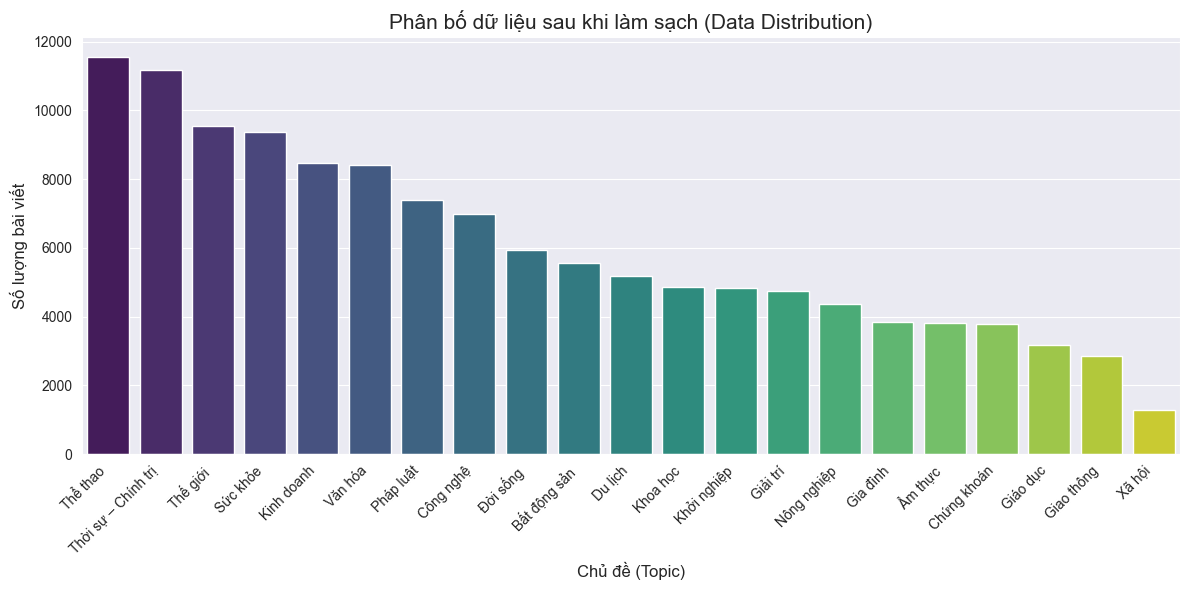

Tổng số bài viết sạch: 127160
                  Topic  Count
15             Thể thao  11553
16  Thời sự – Chính trị  11172
14             Thế giới   9546
13             Sức khỏe   9381
10           Kinh doanh   8462
17              Văn hóa   8405
12            Pháp luật   7404
2             Công nghệ   6983
19             Đời sống   5950
0          Bất động sản   5551
3               Du lịch   5185
8              Khoa học   4854
9           Khởi nghiệp   4844
7              Giải trí   4752
11          Nông nghiệp   4380
4              Gia đình   3855
20              Ẩm thực   3824
1           Chứng khoán   3774
6              Giáo dục   3173
5            Giao thông   2840
18               Xã hội   1272


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

topic_counts = {}
for topic_dir in DATA_ROOT.iterdir():
    if topic_dir.is_dir():
        count = len(list(topic_dir.glob("*.txt")))
        if count > 0:
            topic_counts[topic_dir.name] = count

# Chuyển sang DataFrame để vẽ
df_stats = pd.DataFrame(list(topic_counts.items()), columns=['Topic', 'Count'])
df_stats = df_stats.sort_values('Count', ascending=False)

# 2. Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x='Topic', y='Count', data=df_stats, palette='viridis')

plt.title('Phân bố dữ liệu sau khi làm sạch (Data Distribution)', fontsize=15)
plt.xlabel('Chủ đề (Topic)', fontsize=12)
plt.ylabel('Số lượng bài viết', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('final_data_distribution.png', dpi=300)
plt.show()

print("Tổng số bài viết sạch:", df_stats['Count'].sum())
print(df_stats)